# Image classification via fine-tuning with EfficientNet

**Author:** [Yixing Fu](https://github.com/yixingfu)<br>
**Date created:** 2020/06/30<br>
**Last modified:** 2020/07/16<br>
**Description:** Use EfficientNet with weights pre-trained on imagenet for Stanford Dogs classification.

# Experiment with Bilinear CNN
Bilinear CNN paper: http://vis-www.cs.umass.edu/bcnn/
With code from: https://github.com/NiFangBaAGe/FBCNN/blob/master/load_model.py

Self-connected Bilinear like Breast Cancer paper
https://www.frontiersin.org/articles/10.3389/fgene.2020.547327/full

Use Stanford Dogs. A subset of ImageNet-1k chosen for the task of fine-grained image categorization AKA texture AKA fluffiness.
https://www.tensorflow.org/datasets/catalog/stanford_dogs

Rotate the EfficientNet output vectors with PCA to create "meatier" feature vectors.

In [1]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from sklearn.decomposition import IncrementalPCA as PCA

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()


Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


When the dataset include images with various size, we need to resize them into a
shared size. The Stanford Dogs dataset includes only images at least 200x200
pixels in size. Here we resize the images to the input size needed for EfficientNet.

In [4]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

### Visualizing the data

The following code shows the first 9 images with their labels.

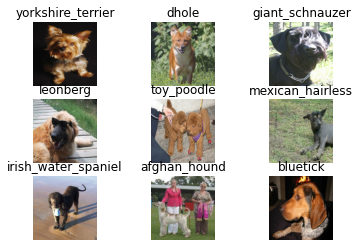

In [5]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


### Data augmentation

We can use the preprocessing layers APIs for image augmentation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

This `Sequential` model object can be used both as a part of
the model we later build, and as a function to preprocess
data before feeding into the model. Using them as function makes
it easy to visualize the augmented images. Here we plot 9 examples
of augmentation result of a given figure.

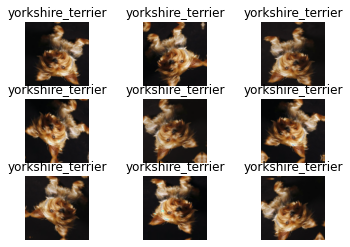

In [7]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


### Prepare inputs

Once we verify the input data and augmentation are working correctly,
we prepare dataset for training. The input data are resized to uniform
`IMG_SIZE`. The labels are put into one-hot
(a.k.a. categorical) encoding. The dataset is batched.

Note: `prefetch` and `AUTOTUNE` may in some situation improve
performance, but depends on environment and the specific dataset used.
See this [guide](https://www.tensorflow.org/guide/data_performance)
for more information on data pipeline performance.

In [8]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


A little code for plotting the results.

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


# plot_hist(hist)

# PCA Rotation Matrix
Create a PCA projection matrix from EfficientNetB0 vectors based on training dataset.

In [10]:
NUM_FEATURES=7*7*120

def build_model(num_classes, output_size=NUM_FEATURES):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = sub_model(inputs)
    # x = layers.Reshape((7*7*NUM_FEATURES,1))(x)
    # print(x.shape)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
bare_model = build_model(NUM_CLASSES)


In [16]:
pca = PCA()

PCA_FEATURES = batch_size *16

batches = np.zeros((PCA_FEATURES, NUM_FEATURES), dtype='float32')
index = 0
sample = None
prev_x = None

for (images, labels) in ds_train:
    # print(images.shape)
    pred = bare_model.predict(images)
    # print(pred.shape)
    flat = pred.reshape((64, NUM_FEATURES))
    if sample is None:
        sample = flat[0].reshape((NUM_FEATURES))
        print('sample:', sample)
    for i in range(flat.shape[0]):
        single = flat[i].reshape((NUM_FEATURES,))
        batches[index + i] = single
    index = index + flat.shape[0]
    if index == batches.shape[0]:
        pca.partial_fit(batches)
        x = pca.transform(sample.reshape((-1, NUM_FEATURES)))
        # print(x.shape, x[0,:6])
        if prev_x is not None:
            print('mean delta:', np.mean(np.abs(prev_x - x)))
        index = 0
        prev_x = x

print('matrix:', pca.components_.shape)

x = pca.transform(batches)
print(x.shape)
print(pca.components_)

sample: [0.00842415 0.0095576  0.0072074  ... 0.00653544 0.00889483 0.01216238]


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_incremental_pca.py:348: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


mean delta: 0.02728545718853738
mean delta: 0.02543582856742891
mean delta: 0.025615694337053907
mean delta: 0.025102396999390444
mean delta: 0.02492191576613812
mean delta: 0.023932906671716693
mean delta: 0.024218915397205627
mean delta: 0.023745728936642
mean delta: 0.024678406461250364
mean delta: 0.023311368015995603
matrix: (1024, 5880)
(1024, 1024)
[[ 3.83392733e-04  3.13996488e-05  6.13446571e-05 ...  8.07740176e-04
   6.65935180e-04  4.22123188e-04]
 [ 1.16359513e-04 -9.47659720e-04  4.90749749e-04 ...  7.79811861e-04
   1.35329980e-03 -2.01798215e-04]
 [-1.19097065e-04  6.61696798e-05 -1.27605311e-03 ...  5.16576234e-04
   6.16404249e-04  3.81976204e-06]
 ...
 [ 8.00651852e-03  8.93551897e-04  8.56719574e-04 ... -5.96562922e-03
   3.76622811e-03  3.70290370e-03]
 [ 7.53967504e-03 -1.44986840e-03  7.03411677e-03 ...  3.94845931e-03
  -2.82668035e-04  5.87217405e-04]
 [-7.88867395e-04  6.91732541e-04  7.14427909e-03 ...  2.13256036e-03
   2.92983975e-03  4.13315702e-03]]


In [15]:
print(pca.n_samples_seen_)

11968


# Bilinear CNN
This layer creates a matrix where the columns are the channel values for all feature maps, and the rows are height X width of the feature maps. It then creates the 'outer product' of the matrix multiplied against itself.

In [ ]:
!pip install -q git+https://github.com/LanceNorskog/keras-fbcnn.git
from keras_fbcnn import BilinearCNN2D

## Transfer learning from pre-trained weights

Here we initialize the model with pre-trained ImageNet weights,
and we fine-tune it on our own dataset.

In [ ]:

def build_model(num_classes, bilinear=False):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    eff = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    # Freeze the pretrained weights
    eff.trainable = False
    sub_model = tf.keras.Model(inputs, eff.output, name='effb0')
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    sub_layer = sub_model(inputs)

    # Build either bilinear or classic global-average-pooling top
    if bilinear:
        x = BilinearCNN2D()([sub_layer, sub_layer])
    else:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(sub_layer)
        x = layers.BatchNormalization()(x)
        top_dropout_rate = 0.2
        x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return eff, model


For the sake of benchmarking, we will create a model, compile the tensor graph, and throw it away- just to warm up the tensor compiler.

In [ ]:
import time
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES)
    prediction = model.predict(np.zeros((1,IMG_SIZE,IMG_SIZE,3)))
    t1 = time.perf_counter()
    prediction = model.predict(np.zeros((128, IMG_SIZE, IMG_SIZE, 3)))
    t2 = time.perf_counter()
    print('(original) time taken to run:',t2-t1)
    print('(original) time taken per image:', (t2-t1)/128)
    block_model, model = build_model(num_classes=NUM_CLASSES, bilinear=True)
    prediction = model.predict(np.zeros((1,IMG_SIZE,IMG_SIZE,3)))
    t1 = time.perf_counter()
    prediction = model.predict(np.zeros((128, IMG_SIZE, IMG_SIZE, 3)))
    t2 = time.perf_counter()
    print('(bilinear) time taken to run:',t2-t1)
    print('(bilinear) time taken per image:', (t2-t1)/128)



First, train a standard classification top.

In [ ]:
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES)

epochs = 80  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

In [ ]:
_, generic_accuracy_train =  model.evaluate(ds_train)
_, generic_accuracy_test =  model.evaluate(ds_test)

Next, train a Bilinear top.

In [ ]:
with strategy.scope():
    block_model, model = build_model(num_classes=NUM_CLASSES, bilinear=True)

epochs = 80  # @param {type: "slider", min:2, max:80}
model.summary()
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, 
                callbacks=[early_stopping], verbose=2)
plot_hist(hist)

In [ ]:
_, bilinear_accuracy_train =  model.evaluate(ds_train)
_, bilinear_accuracy_test =  model.evaluate(ds_test)

In [ ]:
print('Accuracy for Generic Top, Training/Testing\n\t', generic_accuracy_train, '\n\t', generic_accuracy_test)
print('Accuracy for Bilinear Top, Training/Testing\n\t', bilinear_accuracy_train, '\n\t', bilinear_accuracy_test)